In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import yaml
from types import SimpleNamespace

import sys, os
from pathlib import Path

# 1) figure out your project root (one level up from this notebook)
project_root = Path().resolve().parent

# 2) add it to the front of sys.path
sys.path.insert(0, str(project_root))

from src.data.dataloader import EML_Dataset
from src.models.moclip import build_moclip
from hydra import initialize, compose

import tqdm as tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
%%bash
nvidia-smi

Sun Aug 10 18:28:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.158.01             Driver Version: 570.158.01     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:41:00.0 Off |                  Off |
| 30%   46C    P0            123W /  480W |    3671MiB /  24564MiB |     80%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#Dataloader
root = '/home/rodionsa/Data/EML_Datasets/EML_466k_dataset_bias.npz'
Dataset = EML_Dataset(root)

total_len = len(Dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

train_ds, val_ds, test_ds = torch.utils.data.random_split(
    Dataset, [train_len, val_len, test_len],
    generator = torch.Generator().manual_seed(42)
)


In [3]:
#Use dataloader
train_loader = DataLoader(train_ds, batch_size=3000, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=3000, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=3000, shuffle=False)

dataset_loader = DataLoader(Dataset, batch_size=3000, shuffle=False)

In [2]:
#Donwload MOCLIP
# Load YAML config file
with open('../src/models/config.yaml', 'r') as file:
    cfg_dict = yaml.safe_load(file)

# Convert to SimpleNamespace for easy attribute access
cfg = SimpleNamespace(**cfg_dict)

moclip = build_moclip(cfg)
moclip = moclip.to(device)

In [4]:
torch.save(moclip.state_dict(), '../src/models/moclip.pth')

In [ ]:
#Process data
geom_embeddings_full = []
spectra_embeddings_full = []
spectra_full = []
for sample in tqdm.tqdm(dataset_loader):
    geom, params, _, _, spectra = sample
    geom = geom.to(device)
    params = params.to(device)
    spectra = spectra.to(device)  # Ensure spectra is 3D tensor [1, spectra_dim]
    
    geometry_embeddings = F.normalize(moclip.geometry_encoder(geom, params), p=2, dim=-1)
    spectra_embeddings = F.normalize(moclip.spectra_encoder(spectra), p=2, dim=-1)
    geom_embeddings_full.append(geometry_embeddings)
    spectra_embeddings_full.append(spectra_embeddings)
    spectra_full.append(spectra)

geom_embeddings_full = torch.cat(geom_embeddings_full, dim=0)
spectra_embeddings_full = torch.cat(spectra_embeddings_full, dim=0)
spectra_full = torch.cat(spectra_full, dim=0)

100%|██████████| 156/156 [00:28<00:00,  5.39it/s]


206.5263967514038


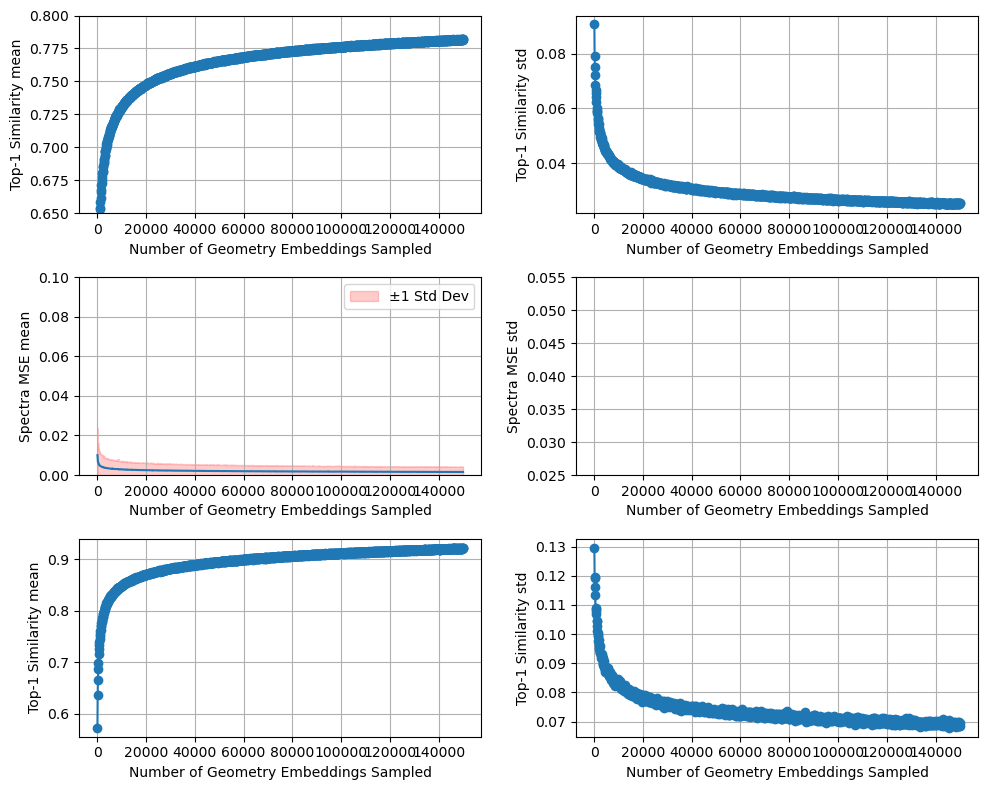

In [6]:
start = time.time()

num_targets = 10000
max_samples = 150000 
step_size = 100

# Generate 5000 random target spectra embeddings
target_embeddings = []
target_spectra_full = []
target_geom_embeddings = []
for _ in range(num_targets):
    idx = torch.randint(0, len(Dataset), (1,)).item()
    geom, params, _, _, target_spectra = Dataset[idx]
    target_spectra = target_spectra.to(device).unsqueeze(0)
    geom = geom.to(device).unsqueeze(0)
    params = params.to(device).unsqueeze(0)

    emb = F.normalize(moclip.spectra_encoder(target_spectra), p=2, dim=-1)
    emb_geom = F.normalize(moclip.geometry_encoder(geom, params), p=2, dim=-1)

    target_embeddings.append(emb)
    target_geom_embeddings.append(emb_geom)
    target_spectra_full.append(target_spectra)

target_spectra_full = torch.cat(target_spectra_full, dim=0).squeeze(1)
target_embeddings = torch.cat(target_embeddings, dim=0)  # shape: [5000, embedding_dim]
target_geom_embeddings = torch.cat(target_geom_embeddings, dim=0)  # shape: [5000, embedding_dim]

similarity_mean = []
similarity_std = []
similarity_geom = []
similarity_geom_mean = []
similarity_geom_std = []
spectra_mse_mean_all = []
spectra_mse_std_all = []
spectra_mse_all = []
for i in range(1, max_samples//step_size + 1):
    num_samples = step_size * i
    sample_indices = torch.randint(0, len(geom_embeddings_full), (num_samples,))
    probe = geom_embeddings_full[sample_indices]  # shape: [num_samples, embedding_dim]

    sim = torch.matmul(target_embeddings, probe.T)  # shape: [5000, num_samples]
    sim_top1 = torch.topk(sim, k=1, dim=-1).values  # shape: [5000, 1]
    sim_top1_ind = torch.topk(sim, k=1, dim=-1).indices[:,0]  # shape: [5000]

    sim_geom = torch.matmul(target_geom_embeddings, probe.T)  # shape: [5000, num_samples]
    sim_geom_top1 = sim_geom[torch.arange(sim_geom.shape[0]), sim_top1_ind]

    spectra_mse = (torch.mean((target_spectra_full - spectra_full[sample_indices[sim_top1_ind.cpu()]]) ** 2, dim=-1))  # shape: [5000]
    spectra_mse_mean = spectra_mse.mean().cpu().item()
    spectra_mse_std = spectra_mse.std().cpu().item()
    

    spectra_mse_mean_all.append(spectra_mse_mean)
    spectra_mse_std_all.append(spectra_mse_std)
    spectra_mse_all.append(spectra_mse.cpu())

    mean_sim = sim_top1.mean().cpu().item()
    std_sim = sim_top1.std().cpu().item()
    similarity_mean.append(mean_sim)
    similarity_std.append(std_sim)

    mean_sim_geom = sim_geom_top1.mean().cpu().item()
    std_sim_geom = sim_geom_top1.std().cpu().item()
    similarity_geom_mean.append(mean_sim_geom)
    similarity_geom_std.append(std_sim_geom)
    similarity_geom.append(sim_geom_top1.cpu())

spectra_mse_mean_all = torch.tensor(spectra_mse_mean_all)
spectra_mse_std_all = torch.tensor(spectra_mse_std_all)
spectra_mse_all = torch.stack(spectra_mse_all, dim=1)  # shape: [5000, num_samples//step_size]
similarity_geom = torch.stack(similarity_geom, dim=1)  # shape: [5000, num_samples//step_size]

end = time.time()
print(end-start)
# Plot
plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_mean, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity mean')
plt.ylim([0.65, 0.8])
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_std, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity std')
#plt.ylim([0.65, 0.8])
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(range(step_size, max_samples + 1, step_size), spectra_mse_mean_all)
plt.fill_between(range(step_size, max_samples + 1, step_size), 
                 spectra_mse_mean_all - spectra_mse_std_all, 
                 spectra_mse_mean_all + spectra_mse_std_all, 
                 color='red', alpha=0.2, label='±1 Std Dev')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Spectra MSE mean')
plt.ylim([0.0, 0.1])
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(range(step_size, max_samples + 1, step_size), spectra_mse_std_all, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Spectra MSE std')
plt.ylim([0.025, 0.055])
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_geom_mean, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity mean')
#plt.ylim([0.65, 0.8])
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_geom_std, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity std')
#plt.ylim([0.65, 0.8])
plt.grid(True)

plt.tight_layout()

In [ ]:
start = time.time()

num_targets = 10000
max_samples = 150000 
step_size = 100

# Generate 5000 random target geometry embeddings
target_embeddings = []
spectra_full = []
target_spectra_embeddings = []
for _ in range(num_targets):
    idx = torch.randint(0, len(Dataset), (1,)).item()
    target_geom, target_params, _, _, spectra = Dataset[idx]
    target_geom = target_geom.to(device).unsqueeze(0)
    spectra = spectra.to(device).unsqueeze(0)
    target_params = params.to(device).unsqueeze(0)

    emb_spectra = F.normalize(moclip.spectra_encoder(spectra), p=2, dim=-1)
    emb = F.normalize(moclip.geometry_encoder(target_geom, target_params), p=2, dim=-1)

    target_embeddings.append(emb)
    target_spectra_embeddings.append(emb_spectra)
    spectra_full.append(spectra)

spectra_full = torch.cat(spectra_full, dim=0).squeeze(1)
target_embeddings = torch.cat(target_embeddings, dim=0)  # shape: [5000, embedding_dim]
target_spectra_embeddings = torch.cat(target_spectra_embeddings, dim=0)  # shape: [5000, embedding_dim]

similarity_mean = []
similarity_std = []
similarity_geom = []
similarity_geom_mean = []
similarity_geom_std = []
spectra_mse_mean_all = []
spectra_mse_std_all = []
spectra_mse_all = []
for i in range(1, max_samples//step_size + 1):
    num_samples = step_size * i
    sample_indices = torch.randint(0, len(geom_embeddings_full), (num_samples,))
    probe = geom_embeddings_full[sample_indices]  # shape: [num_samples, embedding_dim]

    sim = torch.matmul(target_embeddings, probe.T)  # shape: [5000, num_samples]
    sim_top1 = torch.topk(sim, k=1, dim=-1).values  # shape: [5000, 1]
    sim_top1_ind = torch.topk(sim, k=1, dim=-1).indices[:,0]  # shape: [5000]

    sim_geom = torch.matmul(target_geom_embeddings, probe.T)  # shape: [5000, num_samples]
    sim_geom_top1 = sim_geom[torch.arange(sim_geom.shape[0]), sim_top1_ind]

    spectra_mse = (torch.mean((target_spectra_full - spectra_full[sample_indices[sim_top1_ind.cpu()]]) ** 2, dim=-1))  # shape: [5000]
    spectra_mse_mean = spectra_mse.mean().cpu().item()
    spectra_mse_std = spectra_mse.std().cpu().item()
    

    spectra_mse_mean_all.append(spectra_mse_mean)
    spectra_mse_std_all.append(spectra_mse_std)
    spectra_mse_all.append(spectra_mse.cpu())

    mean_sim = sim_top1.mean().cpu().item()
    std_sim = sim_top1.std().cpu().item()
    similarity_mean.append(mean_sim)
    similarity_std.append(std_sim)

    mean_sim_geom = sim_geom_top1.mean().cpu().item()
    std_sim_geom = sim_geom_top1.std().cpu().item()
    similarity_geom_mean.append(mean_sim_geom)
    similarity_geom_std.append(std_sim_geom)
    similarity_geom.append(sim_geom_top1.cpu())

spectra_mse_mean_all = torch.tensor(spectra_mse_mean_all)
spectra_mse_std_all = torch.tensor(spectra_mse_std_all)
spectra_mse_all = torch.stack(spectra_mse_all, dim=1)  # shape: [5000, num_samples//step_size]
similarity_geom = torch.stack(similarity_geom, dim=1)  # shape: [5000, num_samples//step_size]

end = time.time()
print(end-start)
# Plot
plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_mean, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity mean')
plt.ylim([0.65, 0.8])
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_std, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity std')
#plt.ylim([0.65, 0.8])
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(range(step_size, max_samples + 1, step_size), spectra_mse_mean_all)
plt.fill_between(range(step_size, max_samples + 1, step_size), 
                 spectra_mse_mean_all - spectra_mse_std_all, 
                 spectra_mse_mean_all + spectra_mse_std_all, 
                 color='red', alpha=0.2, label='±1 Std Dev')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Spectra MSE mean')
plt.ylim([0.0, 0.1])
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(range(step_size, max_samples + 1, step_size), spectra_mse_std_all, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Spectra MSE std')
plt.ylim([0.025, 0.055])
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_geom_mean, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity mean')
#plt.ylim([0.65, 0.8])
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(range(step_size, max_samples + 1, step_size), similarity_geom_std, marker='o')
plt.xlabel('Number of Geometry Embeddings Sampled')
plt.ylabel('Top-1 Similarity std')
#plt.ylim([0.65, 0.8])
plt.grid(True)

plt.tight_layout()

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 6.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 8.000e+00, 4.000e+00, 7.000e+00, 4.000e+00,
        5.000e+00, 8.000e+00, 7.000e+00, 3.000e+00, 5.000e+00, 1.500e+01,
        7.000e+00, 1.700e+01, 1.300e+01, 2.100e+01, 1.700e+01, 1.800e+01,
        1.800e+01, 2.700e+01, 2.700e+01, 3.500e+01, 2.000e+01, 3.100e+01,
        3.300e+01, 2.900e+01, 4.400e+01, 4.800e+01, 5.900e+01, 6.400e+01,
        4.600e+01, 5.500e+01, 7.000e+01, 6.100e+01, 6.900e+01, 9.300e+01,
        8.500e+01, 8.500e+01, 1.150e+02, 1.150e+02, 1.320e+02, 1.460e+02,
        1.640e+02, 1.600e+02, 1.700e+02, 1.890e+02, 1.880e+02, 2.180e+02,
        2.120e+02, 2.470e+02, 2.810e+0

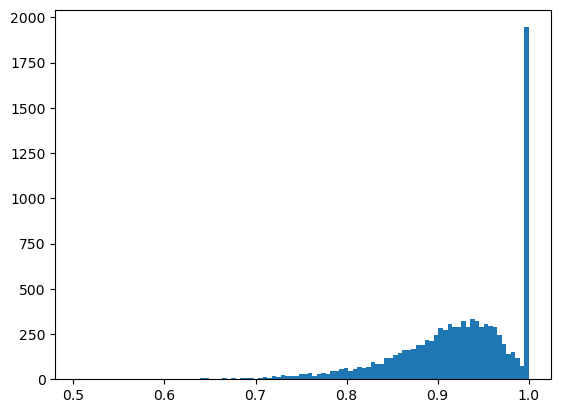

In [14]:
plt.hist(sim_geom_top1.cpu(), bins=100)

In [7]:
import numpy as np
np.savez('Zero-shot_metrics.npz',
         similarity_mean=similarity_mean,
         similarity_std=similarity_std,
         similarity_geom_mean=similarity_geom_mean,
         similarity_geom_std=similarity_geom_std,
         spectra_rmse_mean=spectra_mse_mean_all.cpu().numpy(),
         spectra_rmse_std=spectra_mse_std_all.cpu().numpy(),
         spectra_mse=spectra_mse_all.cpu().numpy(),
         similarity_geom=similarity_geom.cpu().numpy())

In [8]:

start = time.time()
num_targets = 10000

# Generate 5000 random target spectra embeddings
target_embeddings = []
target_spectra_full = []
target_geom_embeddings = []
for _ in range(num_targets):
    idx = torch.randint(0, len(Dataset), (1,)).item()
    geom, params, _, _, target_spectra = Dataset[idx]
    target_spectra = target_spectra.to(device).unsqueeze(0)
    geom = geom.to(device).unsqueeze(0)
    params = params.to(device).unsqueeze(0)

    emb = F.normalize(moclip.spectra_encoder(target_spectra), p=2, dim=-1)
    emb_geom = F.normalize(moclip.geometry_encoder(geom, params), p=2, dim=-1)

    target_embeddings.append(emb)
    target_geom_embeddings.append(emb_geom)
    target_spectra_full.append(target_spectra)

target_spectra_full = torch.cat(target_spectra_full, dim=0).squeeze(1)
target_embeddings = torch.cat(target_embeddings, dim=0)  # shape: [5000, embedding_dim]
target_geom_embeddings = torch.cat(target_geom_embeddings, dim=0)  # shape: [5000, embedding_dim]


num_samples = 50000
sample_indices = torch.randint(0, len(geom_embeddings_full), (num_samples,))
probe = geom_embeddings_full[sample_indices]  # shape: [num_samples, embedding_dim]

sim = torch.matmul(target_embeddings, probe.T)  # shape: [5000, num_samples]
sim_top1 = torch.topk(sim, k=50, dim=-1).values  # shape: [5000, 1]
sim_top1_ind = torch.topk(sim, k=50, dim=-1).indices  # shape: [5000]

# sim_geom = torch.matmul(target_geom_embeddings, probe.T)  # shape: [5000, num_samples]
# sim_geom_top1 = sim_geom[torch.arange(sim_geom.shape[0]), sim_top1_ind]
spectra_mse = []
for k in range(50):
    spectra_mse.append(torch.sqrt(torch.mean((target_spectra_full - spectra_full[sample_indices[sim_top1_ind[:,k].cpu()]]) ** 2, dim=-1)))  # shape: [5000]

spectra_mse = torch.stack(spectra_mse, dim=1)  # shape: [5000, 10]
spectra_mse = spectra_mse.cpu().numpy()
end = time.time()
print(end-start)

27.111154317855835


(0.0, 0.03)

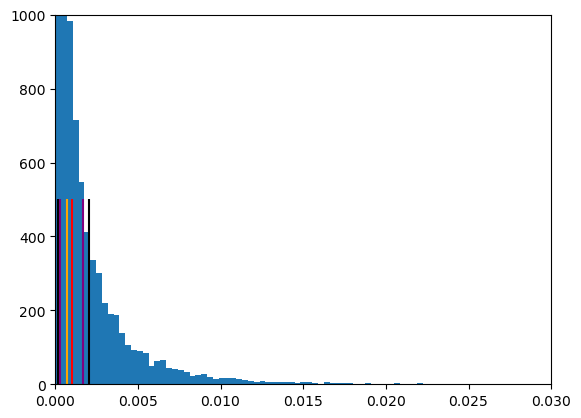

In [102]:
num = 0
plt.hist(spectra_mse[:,num]**2, bins=200)
plt.vlines(spectra_mse[:,num].mean()**2, 0, 500, colors='red')
plt.vlines(np.median(spectra_mse[:,num])**2, 0, 500, colors='orange')
plt.vlines(np.percentile(spectra_mse[:, num], 25)**2, 0, 500, colors='k')
plt.vlines(np.percentile(spectra_mse[:, num], 75)**2, 0, 500, colors='k')
plt.vlines(spectra_mse[:,num].mean()**2 - spectra_mse[:,num].std()**2, 0, 500, colors='purple')
plt.vlines(spectra_mse[:,num].mean()**2 + spectra_mse[:,num].std()**2, 0, 500, colors='purple')

plt.ylim([0, 1000])
plt.xlim([0, 0.03])
#plt.yscale('log')


In [55]:
(spectra_mse[:,0:1].min(axis=1)).mean()

0.0017008629

In [9]:
import numpy as np
mse_k = [np.median(spectra_mse[:, 0:i].min(axis=1)).item()**2 for i in range(1, 51)]
mse_std_k = [spectra_mse[:,0:i].min(axis=1).std().item()**2 for i in range(1, 51)]

mse_k_q25 = [np.percentile(spectra_mse[:, 0:i].min(axis=1), 25) for i in range(1, 51)]
mse_k_q75 = [np.percentile(spectra_mse[:, 0:i].min(axis=1), 75) for i in range(1, 51)]

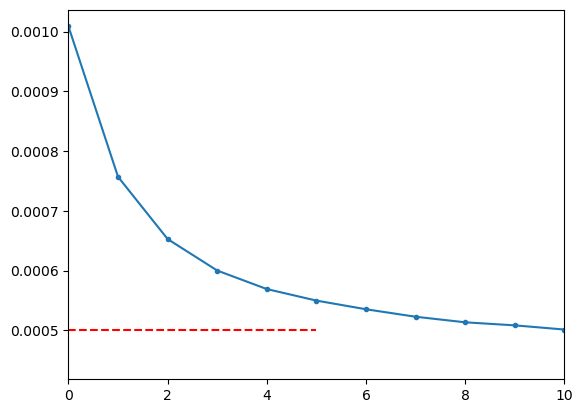

In [11]:
plt.plot(mse_k, '.-')
plt.xlim([0, 10])
plt.hlines(0.0005, 0, 5, color='red', linestyle='--')

In [51]:
spectra_mse[:,0:1]

array([[0.00318709],
       [0.        ],
       [0.00038572],
       ...,
       [0.00019323],
       [0.00119864],
       [0.00015407]], dtype=float32)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 2.000e+0

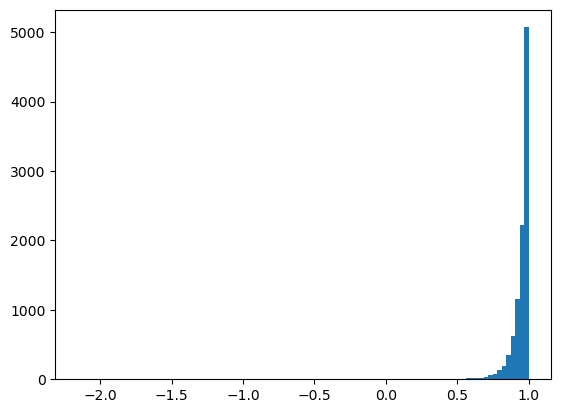

In [10]:
plt.hist(spectra_mse.cpu(), bins=100)

In [11]:
spectra_mse.min()

tensor(-2.1566, device='cuda:0')